# Project 4: Clustering League of Legends Champions

##  Overview
For Project 4, I’m working with a [League of Legends champions dataset](https://www.kaggle.com/datasets/cutedango/league-of-legends-champions) from Kaggle. The goal is to explore and identify **clusters of champions based on their stats and roles**, which may help reveal trends or similarities in how champions are designed for different playstyles.


##  Research Questions

1. **Can we identify clusters of champions with similar roles or tags based on their stats (e.g., HP, attack damage, armor)?**  
2. **How do champions with certain resource types (e.g., Mana, Energy) cluster in terms of base stats and roles?**


## 2. What Is Clustering and How Does It Work?
Clustering is an **unsupervised** machine‑learning technique that groups observations so that those in the same cluster are more similar to each other than to those in other clusters.

- **K‑Means**  
  - Partitions data into *k* groups by minimizing within‑cluster variance (inertia).  
  - Iteratively assigns points to nearest centroid, then recomputes centroids.  
  - **Pros:** fast, easy to interpret. **Cons:** must choose *k*, assumes spherical clusters of similar size.

- **Agglomerative (Hierarchical)**  
  - Builds a tree of clusters by iteratively merging closest pairs.  
  - No need to pre‑specify *k*; you “cut” the dendrogram at your desired level.  
  - **Pros:** reveals nested cluster structure. **Cons:** slower for large datasets, choice of linkage impacts shape.


## Dataset Characteristics

- **167** champions  
- **20+** columns with no missing values  
- Includes champion stats like:
  - Base HP, Mana, Armor, Attack Damage, Speed
  - Roles (e.g., Top, Jungle)
  - Tags (e.g., Fighter, Mage, Tank)
  - Resource Types (e.g., Mana, Energy)


In [6]:
import pandas as pd
df = pd.read_csv('C:/Users/19857/Downloads/LoL_champions.csv')

df.head()

,Name,Tags,Role,Range type,Resourse type,Base HP,HP per lvl,Base mana,Mana per lvl,Movement speed,...,Attack range,HP regeneration,HP regeneration per lvl,Mana regeneration,Mana regeneration per lvl,Attack damage,Attack damage per lvl,Attack speed per lvl,Attack speed,AS ratio
0,Aatrox,Fighter,Top,Melee,Blood Well,650,114,0,0.0,345,...,175,3.00,0.50,0.0,0.0,60,5.00,2.500,0.651,0.651
1,Ahri,"Mage,Assassin",Middle,Ranged,Mana,590,104,418,25.0,330,...,550,2.50,0.60,8.0,0.8,53,3.00,2.200,0.668,0.625
2,Akali,Assassin,"Top,Middle",Melee,Energy,600,119,200,0.0,345,...,125,9.00,0.90,50.0,0.0,62,3.30,3.200,0.625,0.625
3,Akshan,"Marksman,Assassin",Middle,Ranged,Mana,630,107,350,40.0,330,...,500,3.75,0.65,8.2,0.7,52,3.00,4.000,0.638,0.400
4,Alistar,"Tank,Support",Support,Melee,Mana,685,120,350,40.0,330,...,125,8.50,0.85,8.5,0.8,62,3.75,2.125,0.625,0.625


## Exploratory Data Analysis & Visualization

In this section we’ll explore:

1. **Univariate distributions** of each numeric feature to check skew, range, and outliers.  
2. **Pairwise relationships** among key stats to see natural groupings.  
3. **Categorical counts** for Role and Resource type to understand class imbalance.

### Univariate Distributions

We plot histograms with a kernel density estimate (KDE) for each feature.  
This helps us see whether any variables are heavily skewed or have extreme outliers that might later influence clustering.

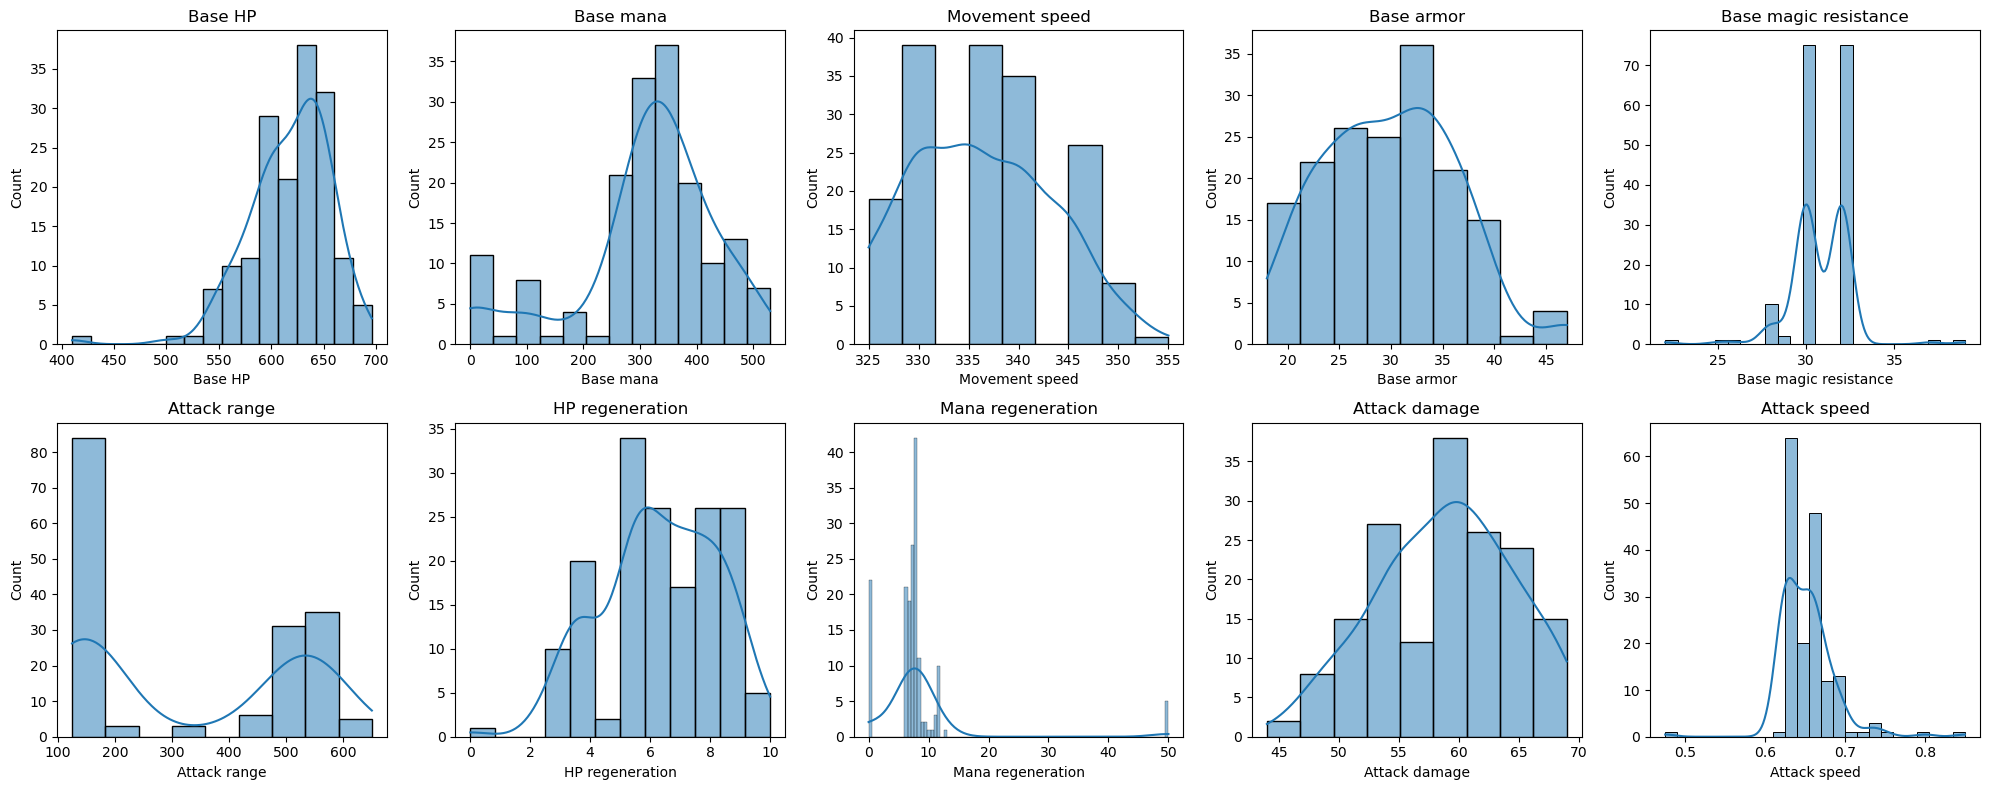

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data & define feature list (if not already defined)
df = pd.read_csv('C:/Users/19857/Downloads/LoL_champions.csv')
features = [
    'Base HP','Base mana','Movement speed','Base armor','Base magic resistance',
    'Attack range','HP regeneration','Mana regeneration','Attack damage','Attack speed'
]

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for ax, feat in zip(axs.flatten(), features):
    sns.histplot(df[feat], ax=ax, kde=True)
    ax.set_title(feat)
plt.tight_layout()
plt.show()

**Interpretation of Univariate Distributions:**  
- **Base HP** is right‑skewed: most champions cluster around 550–650 HP, but a few tanks exceed 800.  
- **Attack Speed** is tightly centered around 0.65 AS, with outliers like Jhin at 0.25.  
- These skews suggest we’ll need standardization (so HP doesn’t dwarf AS) and maybe cap extreme outliers.

### Pairwise Scatterplots

Next, we look at relationships between Base HP, Base Armor, Attack Damage, and Attack Speed, colored by resource type. This reveals any natural clusters before we run an algorithm.

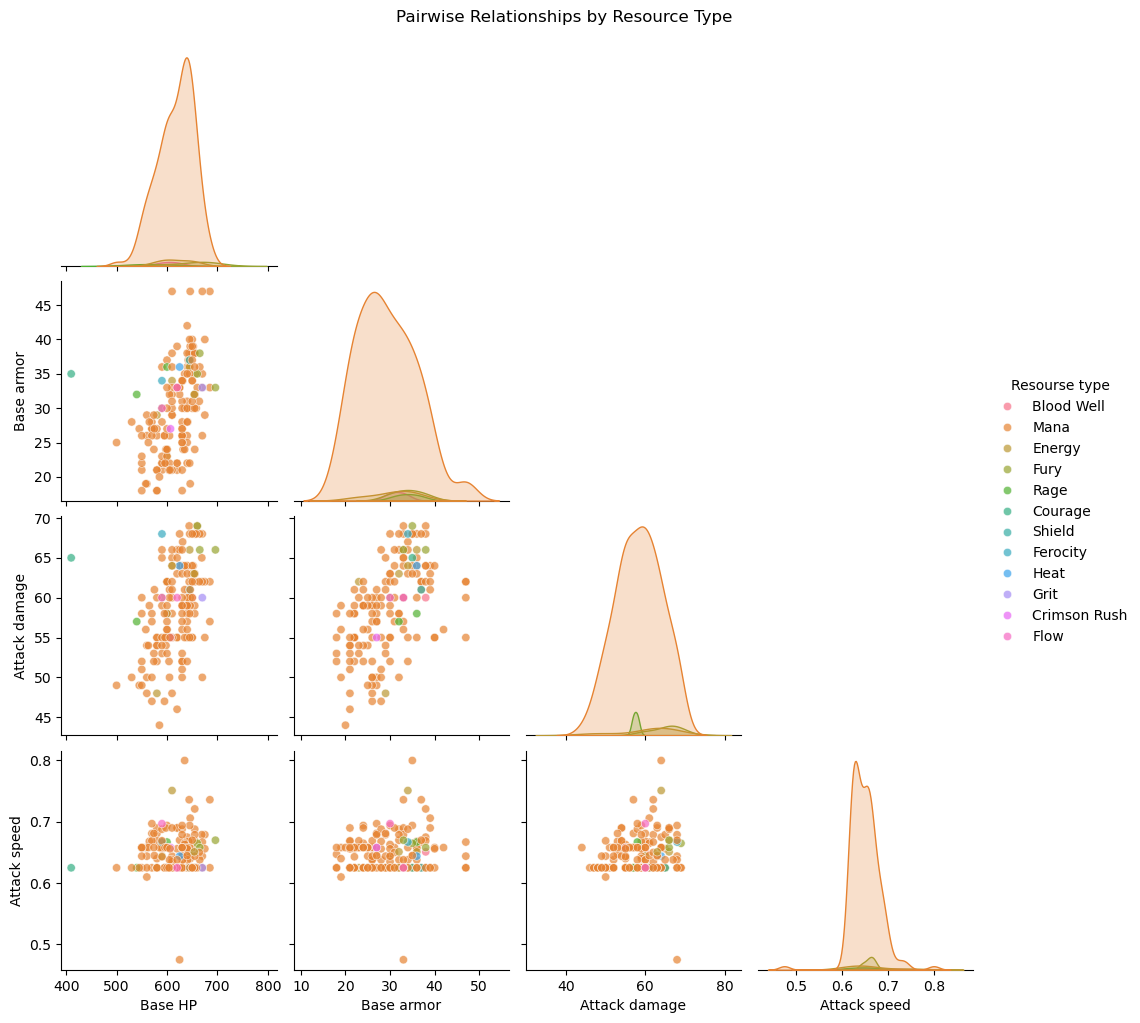

In [84]:
sns.pairplot(
    df,
    vars=['Base HP','Base armor','Attack damage','Attack speed'],
    hue='Resourse type',
    corner=True,
    plot_kws={'alpha':0.7}
)
plt.suptitle("Pairwise Relationships by Resource Type", y=1.02)
plt.show()

**Interpretation of Pairwise Relationships:**  
- Champions with high **Attack Speed** almost always have lower **Base HP**, hinting at an assassin vs. tank divide.  
- **Mana** users (blue points) spread broadly in damage vs. speed space, implying multiple playstyles within Mana champions.

### Categorical Distributions

Finally, we visualize how our champions break down by Role and by Resource type. This tells us if some categories are under‑ or over‑represented.

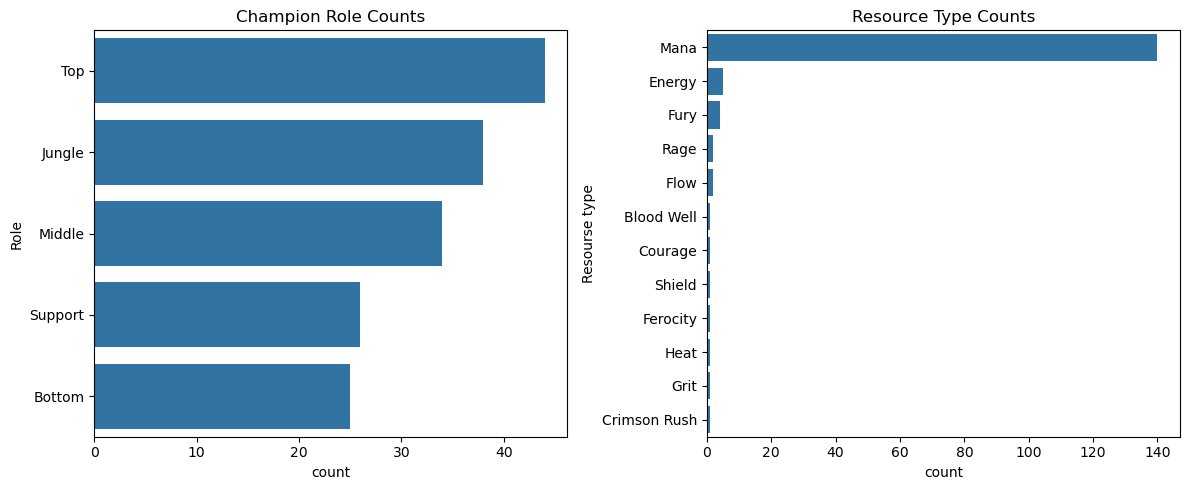

In [88]:
# Ensure only primary roles are included: Top, Mid, Jungle, Support, Bottom
primary_roles = ['Top', 'Middle', 'Jungle', 'Support', 'Bottom']

# Apply a function to clean the role column, splitting by commas if needed
df['Role'] = df['Role'].apply(lambda x: [role for role in x.split(',') if role.strip() in primary_roles][0])

# Now, plot the count plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Champion Role Counts
sns.countplot(
    y='Role',
    data=df,
    order=df['Role'].value_counts().index,
    ax=axes[0]
)
axes[0].set_title('Champion Role Counts')

# Resource Type Counts
sns.countplot(
    y='Resourse type',
    data=df,
    order=df['Resourse type'].value_counts().index,
    ax=axes[1]
)
axes[1].set_title('Resource Type Counts')

# Adjust layout
plt.tight_layout()
plt.show()

**Interpretation of Champion Role Counts:**
- The **Top** role has the most champions, suggesting it’s a common and well-supported lane in the game.
- The **Bottom** role has the fewest champions, indicating that there are fewer specialized champions for this position.

**Interpretation of Resource Type Counts:**
- Most champions use **Mana**, which is the most common resource, while a smaller group uses **Energy** or other resources, reflecting different playstyles and mechanics.

## **Preprocessing**

In this step, we will focus on the following:

- **Focus on Numeric Features Related to Combat Stats:**
    - We'll be using the following numerical features for clustering:
      - `Base HP`, `Base mana`, `Movement speed`, `Base armor`, `Base magic resistance`, 
      - `Attack range`, `HP regeneration`, `Mana regeneration`, `Attack damage`, `Attack speed`.

- **Handle Missing Values:**
    - For the numeric features, we'll replace any missing values with the mean value of the column.

- **Standardize Numerical Features:**
    - To ensure that all numerical features have the same scale, we'll standardize them using `StandardScaler`.

- **Categorical Columns for Later Analysis:**
    - The categorical columns such as `Role`, `Tags`, and `Resource type` will be left aside for further analysis after the clustering step.

These preprocessing steps will help prepare the numeric features for clustering, ensuring that the data is clean, normalized, and ready for model training.


In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Columns for numeric features
numerical_features = [
    'Base HP', 'Base mana', 'Movement speed', 'Base armor', 
    'Base magic resistance', 'Attack range', 'HP regeneration', 
    'Mana regeneration', 'Attack damage', 'Attack speed'
]

# Step 1: Handle missing values for numeric features by filling with the mean
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())  # Standardize features
])

# Apply the transformation to numeric features
df[numerical_features] = numeric_transformer.fit_transform(df[numerical_features])

# Check the transformed data
df[numerical_features].head()

,Base HP,Base mana,Movement speed,Base armor,Base magic resistance,Attack range,HP regeneration,Mana regeneration,Attack damage,Attack speed
0,0.816873,-2.576609,1.256358,1.271452,0.730806,-0.793945,-1.736644,-1.023149,0.202475,-0.036092
1,-0.707916,0.857918,-0.874432,-1.392498,-0.448369,1.151694,-1.999939,-0.015685,-1.036755,0.444961
2,-0.453785,-0.933294,1.256358,-1.079092,3.678742,-1.053364,1.422897,5.273499,0.556540,-0.771819
3,0.308610,0.299191,-0.874432,-0.608983,-0.448369,0.892276,-1.341701,0.009502,-1.213788,-0.403955
4,1.706334,0.299191,-0.874432,2.681778,0.730806,-1.053364,1.159602,0.047281,0.556540,-0.771819


## Standardizing the Features

In [94]:
from sklearn.preprocessing import StandardScaler

X = df[numerical_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[ 0.81687323, -2.57660863,  1.25635761,  1.27145161,  0.73080574,
        -0.79394529, -1.73664414, -1.02314876,  0.20247461, -0.03609164],
       [-0.70791622,  0.85791832, -0.8744317 , -1.39249755, -0.44836874,
         1.15169447, -1.99993925, -0.01568506, -1.03675481,  0.44496072],
       [-0.45378464, -0.9332943 ,  1.25635761, -1.07909177,  3.67874193,
        -1.05336393,  1.42289726,  5.27349936,  0.55654016, -0.77181877],
       [ 0.30861008,  0.29919145, -0.8744317 , -0.60898309, -0.44836874,
         0.89227583, -1.34170146,  0.00950153, -1.21378759, -0.4039552 ],
       [ 1.70633374,  0.29919145, -0.8744317 ,  2.68177763,  0.73080574,
        -1.05336393,  1.15960215,  0.04728142,  0.55654016, -0.77181877]])

### **Modeling (Clustering)**

In this section, we will focus on applying clustering algorithms to group the data based on the combat-related features.

#### **Step 1: Using K-means Clustering with the Elbow Method**

We will start by applying **K-means clustering** for different values of \( k \) (number of clusters) and use the **Elbow Method** to determine the optimal number of clusters

C:\Users\19857\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\19857\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\19857\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\19857\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

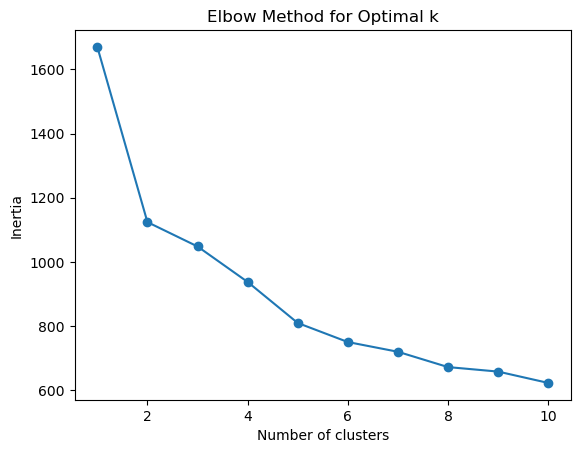

In [97]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method to determine the optimal number of clusters
inertia = []

# Test K-means for different values of k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the inertia to visualize the Elbow
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Step 2: Apply K-means with the Optimal Number of Clusters
Once we have determined the optimal **𝑘** from the Elbow Method, we apply K-means clustering with that number of clusters and inspect the cluster centers and labels.

In [100]:
# Apply K-means with the optimal number of clusters (let's assume k = 3 from the Elbow plot)
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Adding the cluster labels to the original dataframe
df['Cluster'] = y_kmeans

# View the first few rows with the assigned cluster
df[['Base HP', 'Base mana', 'Movement speed', 'Cluster']].head()

C:\Users\19857\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Base HP,Base mana,Movement speed,Cluster
0,0.816873,-2.576609,1.256358,0
1,-0.707916,0.857918,-0.874432,1
2,-0.453785,-0.933294,1.256358,0
3,0.308610,0.299191,-0.874432,2
4,1.706334,0.299191,-0.874432,0


# Cluster Storytelling Analysis

### Insights from Clustering

After applying K-means with k=3 (based on the Elbow method), we identified three distinct clusters in the dataset based on features like `Base HP`, `Base Mana`, and `Movement Speed`.

#### Cluster Distribution

We visualized the clusters in a scatter plot of `Base HP` vs. `Base Mana`:

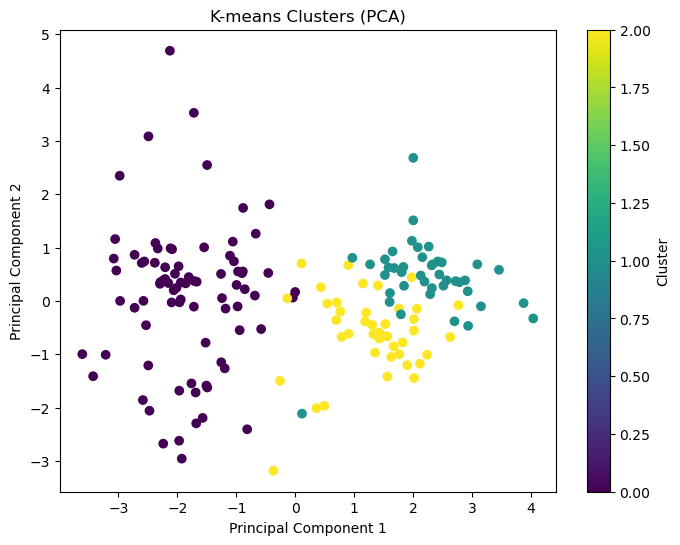

In [106]:
from sklearn.decomposition import PCA

# Reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', marker='o')
plt.title('K-means Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [108]:
print(kmeans.cluster_centers_)

[[ 0.52772108 -0.36595005  0.61538847  0.73636856  0.55824362 -0.90625458
   0.63622283 -0.02459252  0.67312272  0.17441191]
 [-1.02800099  0.76831857 -0.43474502 -0.97462317 -0.60278444  1.03742673
  -0.21329382  0.18655728 -1.1252712  -0.18633628]
 [-0.00225785 -0.05259247 -0.74889683 -0.4522802  -0.4757914   0.71490588
  -1.00492864 -0.13532138 -0.18452727 -0.15059657]]


In [110]:
# Select only numeric columns for mean calculation
numeric_columns = df.select_dtypes(include=['number']).columns
cluster_summary = df[numeric_columns].groupby('Cluster').mean()

print(cluster_summary)

          Base HP  HP per lvl  Base mana  Mana per lvl  Movement speed  \
Cluster                                                                  
0        0.527721  106.158537  -0.365950     35.512195        0.615388   
1       -1.028001   99.809524   0.768319     32.666667       -0.434745   
2       -0.002258  104.209302  -0.052592     42.953488       -0.748897   

         Base armor  Armor per lvl  Base magic resistance  \
Cluster                                                     
0          0.736369       4.704268               0.558244   
1         -0.974623       4.707143              -0.602784   
2         -0.452280       4.472093              -0.475791   

         Magic resistance per lvl  Attack range  HP regeneration  \
Cluster                                                            
0                        2.041463     -0.906255         0.636223   
1                        1.313095      1.037427        -0.213294   
2                        1.367442      0.714906    